In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk, spacy, re, string, unicodedata, contractions
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup
#nltk.download
#nltk.download('wordnet')
#nltk.download('stopwords')

/Users/sammy/opt/anaconda3/envs/NLP_Diaster_Tweets/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from nltk.tokenize import TweetTokenizer

import preprocessor as p

1. Upload the data into Pandas


2. Clean the data.


3. Build a tokenized list of words from the data.


4. Remove stop words, Lemetizing and Stemming, remove words with less frequency(Outliers)


5. Feature Extraction


6. Apply a Logistic Regression model using a feature extraction algorithm bag of words (CountVectorizer)


7. Apply a Logistic Regression model using feature extraction algorithm TfidfVectorizer. (later)


8. Compare the output of each model above. (later)


9. Apply SVM(support vector machine predictor) to bag of words (CountVectorizer) and compare the output with No6 above. (later)


10. Apply SVM(support vector machine predictor) to bag of n-grams model and compare the output with No7 above. (later)

In [3]:
# importing dataset

data = pd.read_csv('train.csv') 


# Reviewing the data shape, columns and stats 

display(data.shape)
display(data.info())
data.describe()

(7613, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [4]:
# Overview of descriptive statistics 

data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
# Percentage of Data Missing Per Column Above 1%

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
missing_data.loc[missing_data['Missing Percent'] > .01][:152]

,Total,Missing Percent
location,2533,33.272035
keyword,61,0.801261


In [6]:
sentences = data['text'].tolist()

In [7]:
sentences

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA 

In [8]:
len(sentences)

7613

In [9]:
sentences_as_one_string = ''.join(sentences)

In [10]:
#!pip install WordCloud

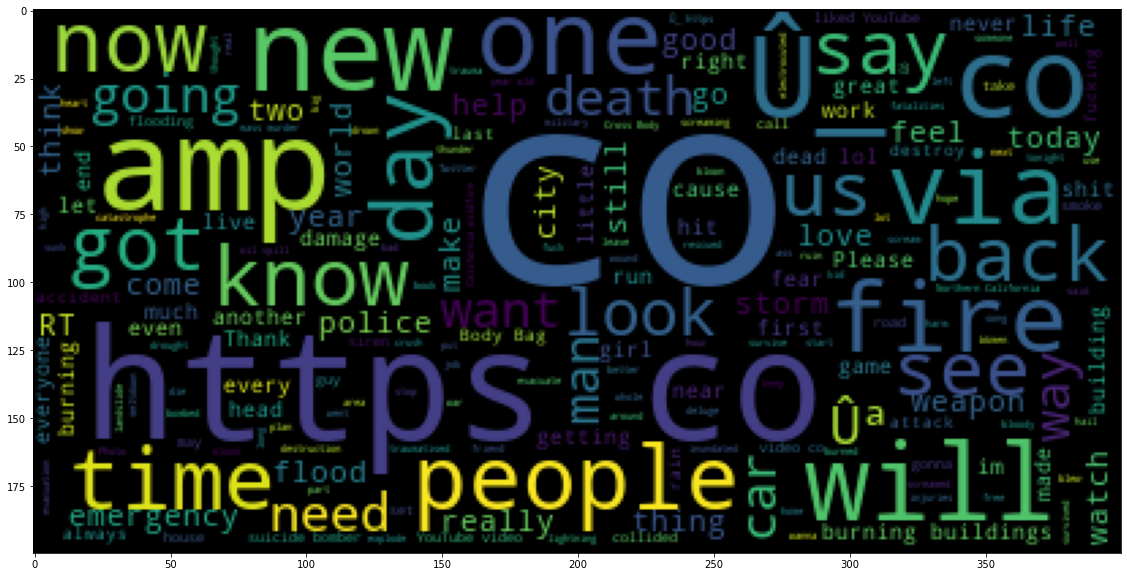

In [11]:
from wordcloud import WordCloud

plt.figure(figsize=(20,10))
plt.imshow(WordCloud().generate(sentences_as_one_string))

In [12]:
# Drop multiple columns by name

data = data.drop(['id'], axis = 1)

In [13]:
data.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
# Reviewing the top 15 value counts in each column

for col in data.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(data[col].value_counts().head(25))


----------------------------------------keyword---------------------------------------- - 

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
explosion      39
whirlwind      39
earthquake     39
derailment     39
wreckage       39
Name: keyword, dtype: int64

----------------------------------------location---------------------------------------- - 

USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Australia            18
Chicago, IL          18
California           17
Everywhere           15
New York, NY         15
California, USA      15
Florida              14
San Francisco        14
United Kingdom       14
Los Angeles          13
Indonesia            13
Washington, D.C.     13
Name: location, dtype: int64

----------------------------------------text---------------------------------------- - 

11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...        10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                      6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                               6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_     6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                  5
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time                4
To fight bioterrorism sir.                                                                                            

----------------------------------------target---------------------------------------- - 

0    4342
1    3271
Name: target, dtype: int64

# 1. Hashtag and Mention Extraction using Regex

List of all hashtags added to a new column as a new feature ‘hashtag’

In [15]:
data['hashtag'] = data['text'].apply(lambda x: re.findall(r'#(\w+)', x))

In [16]:
data['mentions'] = data['text'].str.findall(r'[＠@]([^][\s#<>|{}]+)') 

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   hashtag   7613 non-null   object
 5   mentions  7613 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.0+ KB


In [18]:
data['hashtag'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                                         5870
[hot, prebreak, best]                                        30
[GBBO]                                                       11
[news]                                                        9
[Hiroshima]                                                   8
                                                           ... 
[listia]                                                      1
[Phoenix, Ariz]                                               1
[FREE, Military, Thriller, Suspense, Kindle, amreading]       1
[Desolation, TheConspiracyTheory, NewEP]                      1
[breaking, LA]                                                1
Name: hashtag, Length: 1358, dtype: int64

In [19]:
data['mentions'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                        5595
[YouTube]                                   60
[Change]                                     9
[djicemoon]                                  7
[POTUS]                                      6
                                          ... 
[Raishimi33]                                 1
[greateranglia]                              1
[OhYayyyYay]                                 1
[GerryConnolly, RepDonBeyer, timkaine]       1
[engineshed]                                 1
Name: mentions, Length: 1809, dtype: int64

In [20]:
# # Writing a function to remove the mentions and URLs. strings begining with @
# def remove_mentionsUrls(text):
#     tweet_out = re.sub(r'@[A-Za-z0-9]+', '', text)
#     re.sub('https?://[A-Za-z0-9./1+', '', tweet_out)
#     return tweet_out

# # Writing a function to remove the non numeric characters.
# def remove_nonalphanumeric(text):
#     text_out = ''.join([char for char in text if char not in string.punctuation])
#     return text_out

In [21]:
# # Calling to remove the Mentions and the URLS
# data['Tweet_nomentions_nourl'] = data['text'].apply(lambda x: remove_mentionsUrls(x))

# # Future clean the above 'Tweet noment' by removing the nonalpha numerics
# data['Tweet_nopunc'] = data['Tweet_noment_nourl'].apply(lambda x: remove_nonalphanumeric(x))

# data.head()

In [22]:
#data.iloc[657].text

In [23]:
#sample = data['text'][10]

In [24]:
#sample

In [25]:
#data.head(50)

In [26]:
# from nltk.tokenize import TweetTokenizer
# tweet_tokenizer = TweetTokenizer()

# tweet_tokens = []

# for sent in sample:
    
#     print(tweet_tokenizer.tokenize(sent))
#     tweet_tokens.append(tweet_tokenizer.tokenize(sent))
    
# tweet_tokens

# data['tokenized_tweets'] = 

In [27]:
#sample['tweet_tokens']

In [28]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   hashtag   7613 non-null   object
 5   mentions  7613 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.0+ KB


None

,keyword,location,text,target,hashtag,mentions
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],[]
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],[]
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],[]
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],[]
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[Alaska, wildfires]",[]


# Removing HTML Tags


- Raw text may contain HTML tags especially if the text is exctracted using techniques like web or screen scraping. HTML tags noise and don’t add much value to understanding and analyzing text. Hence, they should be removed. We will use the BeautifulSoup library for removing HTML tags.

In [29]:
def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

In [30]:
data['text'] = data['text'].apply(remove_html_tags)

/Users/sammy/opt/anaconda3/envs/NLP_Diaster_Tweets/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [31]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   hashtag   7613 non-null   object
 5   mentions  7613 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.0+ KB


None

,keyword,location,text,target,hashtag,mentions
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],[]
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],[]
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],[]
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],[]
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[Alaska, wildfires]",[]


# Case-Standardization



- It is one of the most common preprocessing steps in NLP where the text is converted into the same case, more often than not into lower case.



- But this step can lead to information loss in some NLP tasks. For example, in a sentiment analysis task, words written in upper cases can signify strong emotions like anger, excitement, etc. In such cases, we might want to perform this step differently or may even avoid it.

In [32]:
def to_lowercase(text):
    return text.lower()

In [33]:
data['text'] = data['text'].apply(to_lowercase)

In [34]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   hashtag   7613 non-null   object
 5   mentions  7613 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.0+ KB


None

,keyword,location,text,target,hashtag,mentions
0,NaN,NaN,our deeds are the reason of this #earthquake m...,1,[earthquake],[]
1,NaN,NaN,forest fire near la ronge sask. canada,1,[],[]
2,NaN,NaN,all residents asked to 'shelter in place' are ...,1,[],[]
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],[]
4,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,"[Alaska, wildfires]",[]


# Standardizing Accent Characters


- Sometimes, people use accented characters like é, ö, etc. to signify emphasis on a particular letter during pronunciation. In some instances, accent marks also clarify the semantics of words, which might be different without accent marks. Though you might encounter accented characters very rarely, it’s a good practice to convert these characters into standard ASCII characters.

In [35]:
def standardize_accented_chars(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [36]:
data['text'] = data['text'].apply(standardize_accented_chars)

In [37]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   hashtag   7613 non-null   object
 5   mentions  7613 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.0+ KB


None

,keyword,location,text,target,hashtag,mentions
0,NaN,NaN,our deeds are the reason of this #earthquake m...,1,[earthquake],[]
1,NaN,NaN,forest fire near la ronge sask. canada,1,[],[]
2,NaN,NaN,all residents asked to 'shelter in place' are ...,1,[],[]
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],[]
4,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,"[Alaska, wildfires]",[]


# Dealing with URLs


- Many times people use URLs, especially on social media, to provide extra information to the context. The URLs don’t generalize across samples and hence are noise. We can remove URLs using regular expressions.


- Note: 
    > In some tasks, URLs can add extra information to the data. For example, in a text classification task that aims to detect if a social media comment is an advertisement or not, the presence of URLs in a comment can provide useful information. In such a case, we can replace URLs with a custom token like <URL> or add an extra binary feature in the feature vector that corresponds to the presence of a URL.

In [38]:
def remove_url(text):
    return re.sub(r'https?:\S*', '', text)

In [39]:
data['text'] = data['text'].apply(remove_url)

In [40]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   hashtag   7613 non-null   object
 5   mentions  7613 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.0+ KB


None

,keyword,location,text,target,hashtag,mentions
0,NaN,NaN,our deeds are the reason of this #earthquake m...,1,[earthquake],[]
1,NaN,NaN,forest fire near la ronge sask. canada,1,[],[]
2,NaN,NaN,all residents asked to 'shelter in place' are ...,1,[],[]
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],[]
4,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,"[Alaska, wildfires]",[]


# Expanding Contractions


- Contractions are shortened versions of words or syllables. They are created by removing, one or more letters from words. Sometimes, multiple words are combined to create a contraction. For example, I will is contracted into I’ll, do not into don’t. Considering I will and I’ll differently might result in poor performance of the model. Hence, it’s a good practice to convert each contraction into its expanded form. We can use the contractions library to convert contractions into their expanded form.

In [41]:
# def expand_contractions(text):
#     expanded_words = [] 
#     for word in text.split():
#         expanded_words.append(contractions.fix(word)) 
#     return ''.join(expanded_words)

In [42]:
# data['text'] = data['text'].apply(expand_contractions)

In [43]:
# display(data.info())
# data.head()

# Removing Mentions and Hashtags


- This step comes into effect when dealing with social media text data, for example, Tweets. Mentions and hashtags don’t generalize across samples and are noise in most NLP tasks. Hence, it’s better to remove these.


- The above output might make much sense to humans but helps in improving the performance of models.


- Note: 
    > In this step, we are removing text that comes after ‘@’ and ‘#’. Also, this step should be performed
    before removing special characters(a step that we are going to look at next) from the text

In [44]:
def remove_mentions_and_tags(text):
    text = re.sub(r'@\S*', '', text)
    return re.sub(r'#\S*', '', text)

In [45]:
data['text'] = data['text'].apply(remove_mentions_and_tags)

In [46]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   hashtag   7613 non-null   object
 5   mentions  7613 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.0+ KB


None

,keyword,location,text,target,hashtag,mentions
0,NaN,NaN,our deeds are the reason of this may allah fo...,1,[earthquake],[]
1,NaN,NaN,forest fire near la ronge sask. canada,1,[],[]
2,NaN,NaN,all residents asked to 'shelter in place' are ...,1,[],[]
3,NaN,NaN,"13,000 people receive evacuation orders in ca...",1,[wildfires],[]
4,NaN,NaN,just got sent this photo from ruby as smoke f...,1,"[Alaska, wildfires]",[]


# Removing Special Characters


- Special characters are non-alphanumeric characters. The characters like %,$,&, etc are special. In most NLP tasks, these characters add no value to text understanding and induce noise into algorithms. We can use regular expressions for removing special characters.

In [47]:
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat, '', text)

In [48]:
data['text'] = data['text'].apply(remove_special_characters)

In [49]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   hashtag   7613 non-null   object
 5   mentions  7613 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.0+ KB


None

,keyword,location,text,target,hashtag,mentions
0,NaN,NaN,our deeds are the reason of this may allah fo...,1,[earthquake],[]
1,NaN,NaN,forest fire near la ronge sask. canada,1,[],[]
2,NaN,NaN,all residents asked to 'shelter in place' are ...,1,[],[]
3,NaN,NaN,"13,000 people receive evacuation orders in ca...",1,[wildfires],[]
4,NaN,NaN,just got sent this photo from ruby as smoke f...,1,"[Alaska, wildfires]",[]


# Removing Digits


- Digits in the text don’t add extra information to data and induce noise into algorithms. Hence, it’s a good practice to remove digits from the text. Again, we can use regex to achieve this task

In [50]:
def remove_numbers(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

In [51]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   hashtag   7613 non-null   object
 5   mentions  7613 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.0+ KB


None

,keyword,location,text,target,hashtag,mentions
0,NaN,NaN,our deeds are the reason of this may allah fo...,1,[earthquake],[]
1,NaN,NaN,forest fire near la ronge sask. canada,1,[],[]
2,NaN,NaN,all residents asked to 'shelter in place' are ...,1,[],[]
3,NaN,NaN,"13,000 people receive evacuation orders in ca...",1,[wildfires],[]
4,NaN,NaN,just got sent this photo from ruby as smoke f...,1,"[Alaska, wildfires]",[]


# Removing Puncuations


- Again, puncuations don’t add extra information to data in NLP and hence, we remove them

In [52]:
def remove_punctuation(text):
    return ''.join([c for c in text if c not in string.punctuation])

In [53]:
data['text'] = data['text'].apply(remove_punctuation)

In [54]:
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   hashtag   7613 non-null   object
 5   mentions  7613 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.0+ KB


None

,keyword,location,text,target,hashtag,mentions
0,NaN,NaN,our deeds are the reason of this may allah fo...,1,[earthquake],[]
1,NaN,NaN,forest fire near la ronge sask canada,1,[],[]
2,NaN,NaN,all residents asked to shelter in place are be...,1,[],[]
3,NaN,NaN,13000 people receive evacuation orders in cal...,1,[wildfires],[]
4,NaN,NaN,just got sent this photo from ruby as smoke f...,1,"[Alaska, wildfires]",[]


In [55]:
data.head()

,keyword,location,text,target,hashtag,mentions
0,NaN,NaN,our deeds are the reason of this may allah fo...,1,[earthquake],[]
1,NaN,NaN,forest fire near la ronge sask canada,1,[],[]
2,NaN,NaN,all residents asked to shelter in place are be...,1,[],[]
3,NaN,NaN,13000 people receive evacuation orders in cal...,1,[wildfires],[]
4,NaN,NaN,just got sent this photo from ruby as smoke f...,1,"[Alaska, wildfires]",[]


# Lemmatisaton


- Lemmatization generates the root form of words from their inflected forms. For example, for the root word ‘play’, ‘playing’ will be its inflected form. Notice that both play and playing mean almost the same and it would be better if our model considers playing the same as play. To achieve such conversions, we use lemmatization. Lemmatization makes use of vocabulary and morphological analysis of words, to generate the root form of a word. We will use the spaCy library for performing lemmatization.

In [56]:
# nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])

In [57]:
def lemmatize(text):
    
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    
    doc = nlp(text)
    
    lemmatized_text = []
    
    for token in doc:
        lemmatized_text.append(token.lemma_)
        
    return ''.join(lemmatized_text)

In [ ]:
data['lemmatized'] = data['text'].apply(lemmatize)

In [ ]:
data.head()

# Removing Stopwords


- Stopwords like I, am, me, etc, don’t add any information that can help in modeling. Keeping them adds noise and increases the dimensions of feature vectors badly affecting computation cost and model accuracy. Hence it is advisable to remove them. We will use the spacy library to remove stop words. Spacy has 326 words in the set of stop words. In some cases, we might want to add some custom stop words, i.e. the words that are stop words for our tasks but may not be in the spacy’s set of stop words. Also in some NLP tasks, we might want to remove some words from spacy’s stop words set. For example, in sentiment tasks, we would like to keep negation words like ‘not, neither, nor, etc’ in text, hence, we would remove them from spacy’s set of stop words.

In [ ]:
def remove_stopwords(text): 
    
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    
    filtered_sentence = [] 
    
    doc = nlp(text)
    
    for token in doc:
        if token.is_stop == False:
            filtered_sentence.append(token.text)   
            
    return ''.join(filtered_sentence)

In [ ]:
data['text'] = data['text'].apply(remove_stopwords)

In [ ]:
data.head()

In [ ]:
# https://towardsdatascience.com/an-introduction-to-tweettokenizer-for-processing-tweets-9879389f8fe7